# ISE529 Predictive Analytics
**Homework #3**

**Student Name:** `André Ramolivaz` <br>
**NetID:** `3933665317` <br>
**Due Date:** `2025-06-12`

### Setup
Import all required packages below.

In [42]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

---
## Question 1
*20 points*
![Logo Python](11.png)


Assume we have **$K$** classes.
If an observation belongs to class $k$ then

$$
X \mid (Y=k) \sim \mathcal N(\mu_k,\sigma_k^{2}),
\qquad k = 1,\dots ,K,
$$

and the prior probability of class $k$ is $\pi_k$.

By Bayes’ rule the posterior that a point $x$ belongs to class $k$ is

$$
p_k(x)=
\Pr(Y=k\mid X=x)=
\frac{\pi_k\,\varphi(x;\mu_k,\sigma_k^{2})}
     {\displaystyle\sum_{j=1}^{K}\pi_j\,\varphi(x;\mu_j,\sigma_j^{2})},
$$

where

$$
\varphi(x;\mu,\sigma^{2})=
\frac{1}{\sqrt{2\pi}\,\sigma}\,
\exp\!\bigl\{-\frac{(x-\mu)^{2}}{2\sigma^{2}}\bigr\}
$$

is the one–dimensional Gaussian density.
The **Bayes classifier** assigns $x$ to the class with the largest $p_k(x)$.
Instead of comparing these fractions we compare their natural logs (dropping the common denominator).

$$
\begin{aligned}
\delta_k(x)
&=\log\!\bigl[\pi_k\,\varphi(x;\mu_k,\sigma_k^{2})\bigr] \\[4pt]
&=-\tfrac12\log\sigma_k^{2}
  -\frac{(x-\mu_k)^{2}}{2\sigma_k^{2}}
  +\log\pi_k.
\end{aligned}
$$

Expand the quadratic term:

$$
(x-\mu_k)^{2}=x^{2}-2\mu_k x+\mu_k^{2},
$$

so

$$
\boxed{
\delta_k(x)=
-\frac{1}{2\sigma_k^{2}}\,x^{2}
+\frac{\mu_k}{\sigma_k^{2}}\,x
+\Bigl(
-\frac{\mu_k^{2}}{2\sigma_k^{2}}
-\tfrac12\log\sigma_k^{2}
+\log\pi_k
\Bigr)
}.
$$

To decide between any two classes $k$ and $\ell$ we set $\delta_k(x)=\delta_\ell(x)$.
Because the $x^{2}$ coefficients $-\tfrac{1}{2\sigma_k^{2}}$ and $-\tfrac{1}{2\sigma_\ell^{2}}$ are generally **different**, the $x^{2}$ terms do not cancel.
Rearranging yields a **quadratic equation in $x$** whose real roots (if any) are the decision-boundary points.
Hence the Bayes classifier here is **non-linear**.


If all classes shared a common variance, $\sigma_k^{2}=\sigma^{2}$, the quadratic terms would cancel and the boundary would reduce to a **linear** function of $x$—the Linear Discriminant Analysis (LDA) case.
Allowing class-specific variances introduces curvature, producing the Quadratic Discriminant Analysis (QDA) rule.



For a single predictor with class-specific normal distributions $(\mu_k,\sigma_k^{2})$, the Bayes classifier compares quadratic discriminant functions

$$
\delta_k(x)=a_k x^{2}+b_k x+c_k,
$$

where the coefficients $a_k$ differ across classes.
Therefore the resulting classification rule and its decision boundary are quadratic, i.e. **non-linear** in $x$.

---
## Question 2
*25 points*
![Logo Python](12.png)

**(a)**

In [13]:
df = pd.read_csv("titanic_dataset.csv")

df = df[["Survived", "Pclass", "Sex", "Age"]].dropna()

df["Survived"] = df["Survived"].astype(int)
df["Age"]      = pd.to_numeric(df["Age"], errors="coerce")


logit_res = smf.logit("Survived ~ C(Pclass) + C(Sex) + Age", data=df).fit()

print(logit_res.summary())

odds_ratios = np.exp(logit_res.params)
print("\nOdds ratios (exp(coefficients)):")
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.451857
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  887
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            4
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.3223
Time:                        11:50:40   Log-Likelihood:                -400.80
converged:                       True   LL-Null:                       -591.38
Covariance Type:            nonrobust   LLR p-value:                 3.244e-81
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6349      0.370      9.812      0.000       2.909       4.361
C(Pclass)[T.2]   

**(b)**

In [14]:
edges  = list(range(0, 85, 5))                  # 0,5,10,…,80
labels = [f"{edges[i]}–{edges[i+1]}" for i in range(len(edges)-1)]

df["Age_Range"] = pd.cut(df["Age"],
                         bins=edges,
                         labels=labels,
                         right=True,            # intervals (a,b]
                         include_lowest=True)

logit_res_bins = smf.logit(
    "Survived ~ C(Pclass) + C(Sex) + C(Age_Range)",
    data=df
).fit()

print("\n=== logit with Age_Range ===")
print(logit_res_bins.summary())

odds_ratios_bins = np.exp(logit_res_bins.params)
print("\nOdds ratios (exp(coefficients)):")
print(odds_ratios_bins)

print(f"\nAIC  (Age_Numeric) : {logit_res.aic:.1f}")
print(f"AIC  (Age_Range)    : {logit_res_bins.aic:.1f}")

ll_num, ll_bins = logit_res.llf,  logit_res_bins.llf
df_num, df_bins = logit_res.df_model, logit_res_bins.df_model
lr_stat  = 2 * (ll_bins - ll_num)
df_diff  = df_bins - df_num
p_val    = chi2.sf(lr_stat, abs(df_diff))

print(f"LR statistic = {lr_stat:.2f},  df = {df_diff},  p-value = {p_val:.4g}")

         Current function value: 0.436351
         Iterations: 35

=== Modello logit con Age_Range ===
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  887
Model:                          Logit   Df Residuals:                      868
Method:                           MLE   Df Model:                           18
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.3455
Time:                        11:50:43   Log-Likelihood:                -387.04
converged:                      False   LL-Null:                       -591.38
Covariance Type:            nonrobust   LLR p-value:                 1.413e-75
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.4720      0.475      9.422      0.000       3.542       5

The logistic regression that replaces the single numeric variable Age with the 5-year categorical factor Age_Range leads to a model that is demonstrably different from the one fitted in part (a). When all the 17 dummy variables generated by the bins are included, the log-likelihood rises from –400.80 to –387.04, so—purely in-sample—the binned model explains the data a little better. A likelihood-ratio test confirms that this improvement is statistically significant: the χ² statistic is 27.51 with 14 degrees of freedom, yielding a p-value of 0.0165 and rejecting the null hypothesis that the simpler specification is sufficient.

Yet this extra fit comes at a considerable cost. With eighteen free coefficients instead of four, the more complex model pays a much heavier penalty under information criteria. Its AIC rises to 812.1, just above the numeric-age model’s 811.6, indicating that once complexity is taken into account the original specification remains the better choice for prediction and generalisation. The parameter estimates reinforce this results. The key effects of passenger class and sex hardly change—second- and third-class travellers and males still show odds ratios near 0.30 and 0.08, respectively—so the substantive conclusions are identical. The age bins, however, expose practical difficulties: many of the oldest intervals contain very few observations, the optimisation issues flagged by the software reveal near separation, and the corresponding coefficients swing to implausibly large magnitudes. In other words, the binned model is both unstable and harder to interpret, whereas the single slope of –0.034 in the numeric-age model captures the same monotonic decline in survival probability with age in a clean, statistically robust way.

For these reasons the two models are not the same. Although the categorical specification is formally different and marginally improves raw likelihood, it does not deliver a better balance of fit and parsimony, and it introduces estimation problems. The original model with the continuous age covariate therefore remains the preferred representation of the data.

**(c)**

In [16]:
if pd.api.types.is_categorical_dtype(df["Age_Range"]):
    df["Age_Range"] = df["Age_Range"].cat.remove_unused_categories()
else:
    df["Age_Range"] = df["Age_Range"].astype("category")


grp = (
    df
    .groupby(["Pclass", "Sex", "Age_Range"])
    .agg(Survived_count=("Survived", "sum"),
         Total=("Survived", "size"))
    .reset_index()
)

grp["Survived_prop"] = grp["Survived_count"] / grp["Total"]

glm_bin = smf.glm(
    formula="Survived_prop ~ C(Pclass) + C(Sex) + C(Age_Range)",
    data=grp,
    family=sm.families.Binomial(),
    freq_weights=grp["Total"]        # exact equivalence to individ. LL
).fit()

print("\n=== GLM (binomial) on grouped data ===")
print(glm_bin.summary())


print(f"\nAIC  – individual-level model : {logit_res_bins.aic:.1f}")
print(f"AIC  – grouped-data model     : {glm_bin.aic:.1f}")

max_abs_diff = (glm_bin.params - logit_res_bins.params).abs().max()
print(f"max |β_group − β_individual| : {max_abs_diff:.6f}")


=== GLM (binomial) on grouped data ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:          Survived_prop   No. Observations:                   78
Model:                            GLM   Df Residuals:                      868
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -285.74
Date:                Wed, 11 Jun 2025   Deviance:                       129.58
Time:                        12:18:11   Pearson chi2:                     200.
No. Iterations:                    21   Pseudo R-squ. (CS):             0.9947
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

After collapsing the data into one row for every Pclass × Sex × Age_Range cell and fitting a binomial-GLM with frequency weights, we obtain the same specification used in part (b) yet expressed in aggregated form. Because the grouped model converges fully, its coefficients replicate those from part (b) in the well-populated age bins, while the log-likelihood improves (–285.7 vs –387.0) and the AIC falls sharply once the optimisation reaches the exact maximum. Hence:

- Versus part (a) – the grouped model is different: it replaces the single linear age term with 17 dummy variables, so the functional form and inference change.

- Versus part (b) – it is the same model in statistical terms: identical predictors and parameter meanings. The only practical distinction is that the grouped fit achieves convergence, whereas the individual-level run stopped early; once convergence is reached, the two methods yield equivalent estimates and conclusions.

Part (c) confirms that aggregating to a binomial response is an exact, numerically stable alternative to fitting the same logistic regression on individual records, but it does not alter the model’s substantive content; it simply ensures that the specification from part (b) is properly estimated, and it remains distinct from the continuous-age model of part (a).

**(d)**

None of the three fits is outright “wrong,” but only the first can be called satisfactory in the strict sense that it converges cleanly, captures the main structure in the data, and avoids unnecessary complication.

The numeric-age model from part (a) reaches the maximum-likelihood solution in six iterations, its coefficients are stable and interpretable, and its residual deviance (-2 log-likelihood) is in line with its four free parameters. The pseudo-R² of ≈ 0.32 shows that much—but certainly not all—of the survival variation is explained by class, sex, and a linear effect of age. Diagnostic work that we have not run here (Hosmer–Lemeshow, influence plots, ROC curves) would almost certainly reveal some lack of fit, yet nothing in the output flags a fundamental flaw. Within the limited predictor set, the model is adequate.

The individual-record, 17-dummy specification in part (b) is not adequate: the optimiser hits its iteration limit, so the reported coefficients are not the true MLEs; several age-bin estimates diverge, signalling quasi-separation; and the AIC rises above that of model (a) despite the higher log-likelihood, confirming that the extra parameters are not justified.

Part (c) aggregates the data and successfully finds the same likelihood surface that (b) aimed for, but the substantive problems remain. The bins above 65 years still rest on a handful of observations and their coefficients explode to ±2 × 10⁴, a clear warning of numerical and inferential instability. Moreover, although the grouped model attains a far better log-likelihood, its AIC (609 vs 812) is not comparable with the individual-level figures because the likelihood has been rescaled through frequency weights; what matters is that the effective parameter count is high and the extreme-age estimates are unreliable.

Taken together, the evidence points to model (a) as the only defensible baseline among the three. It could still be improved—by allowing a nonlinear spline for age, adding interaction terms, or including other Titanic predictors but it respects the principle of parsimony and gives stable, interpretable results without the convergence and separation issues that undermine models (b) and (c).

---
## Question 3
*20 points*
![Logo Python](13.png)

**(a)**

In [25]:
df = pd.read_csv("highschooldata.csv")

train = df.iloc[:190].copy()
test  = df.iloc[190:].copy()

train["prog"] = train["prog"].astype(int)
test["prog"]  = test["prog"].astype(int)

cat_cols = ["female", "race", "ses", "schtyp"]
num_cols = ["read", "write", "math", "science", "socst"]

X_train = pd.get_dummies(train[cat_cols], drop_first=True)
X_train = pd.concat([X_train, train[num_cols]], axis=1)
X_train = sm.add_constant(X_train)        # intercept

y_train = train["prog"]

mnlogit_res = sm.MNLogit(y_train, X_train).fit()

print(mnlogit_res.summary())

Optimization terminated successfully.
         Current function value: 0.770331
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                   prog   No. Observations:                  190
Model:                        MNLogit   Df Residuals:                      170
Method:                           MLE   Df Model:                           18
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.2376
Time:                        13:15:25   Log-Likelihood:                -146.36
converged:                       True   LL-Null:                       -191.97
Covariance Type:            nonrobust   LLR p-value:                 8.706e-12
    prog=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5787      1.826     -3.604      0.000     -10.157      -3.001
female         0.2042      0.

**(b)**

In [20]:
cat_cols = ["female", "race", "ses", "schtyp"]
num_cols = ["read", "write", "math", "science", "socst"]

X_test = pd.get_dummies(test[cat_cols], drop_first=True)
X_test = pd.concat([X_test, test[num_cols]], axis=1)
X_test = sm.add_constant(X_test, has_constant="add")

probs = mnlogit_res.predict(X_test)
probs.columns = ["academic", "general", "vocational"]

chosen = probs.idxmax(axis=1)          # programme with highest probability

output = (
    test[["prog"]]                     # true programme (numeric)
    .rename(columns={"prog": "true_prog"})
    .assign(
        p_academic   = probs["academic"],
        p_general    = probs["general"],
        p_vocational = probs["vocational"],
        predicted    = chosen.map({"academic":1, "general":2, "vocational":3}),
        chosen_label = chosen
    )
)

print(output.to_string(index=False, float_format="%.3f"))

 true_prog  p_academic  p_general  p_vocational  predicted chosen_label
         3       0.359      0.138         0.504          3   vocational
         1       0.265      0.483         0.252          2      general
         3       0.146      0.822         0.031          2      general
         2       0.088      0.512         0.400          2      general
         2       0.049      0.941         0.010          2      general
         1       0.025      0.965         0.010          2      general
         3       0.199      0.182         0.619          3   vocational
         1       0.094      0.878         0.028          2      general
         1       0.212      0.686         0.102          2      general
         2       0.030      0.936         0.034          2      general


---
## Question 4
*20 points*
![Logo Python](14.png)

**(a)**

In [32]:
auto = pd.read_csv("Auto.csv", na_values="?")

mpg_median = auto["mpg"].median()

auto["mpg01"] = (auto["mpg"] > mpg_median).astype(int)

print("Median mpg:", mpg_median)
print(auto[["mpg", "mpg01"]].head())

Median mpg: 23.0
    mpg  mpg01
0  18.0      0
1  15.0      0
2  18.0      0
3  16.0      0
4  17.0      0


**(b)**

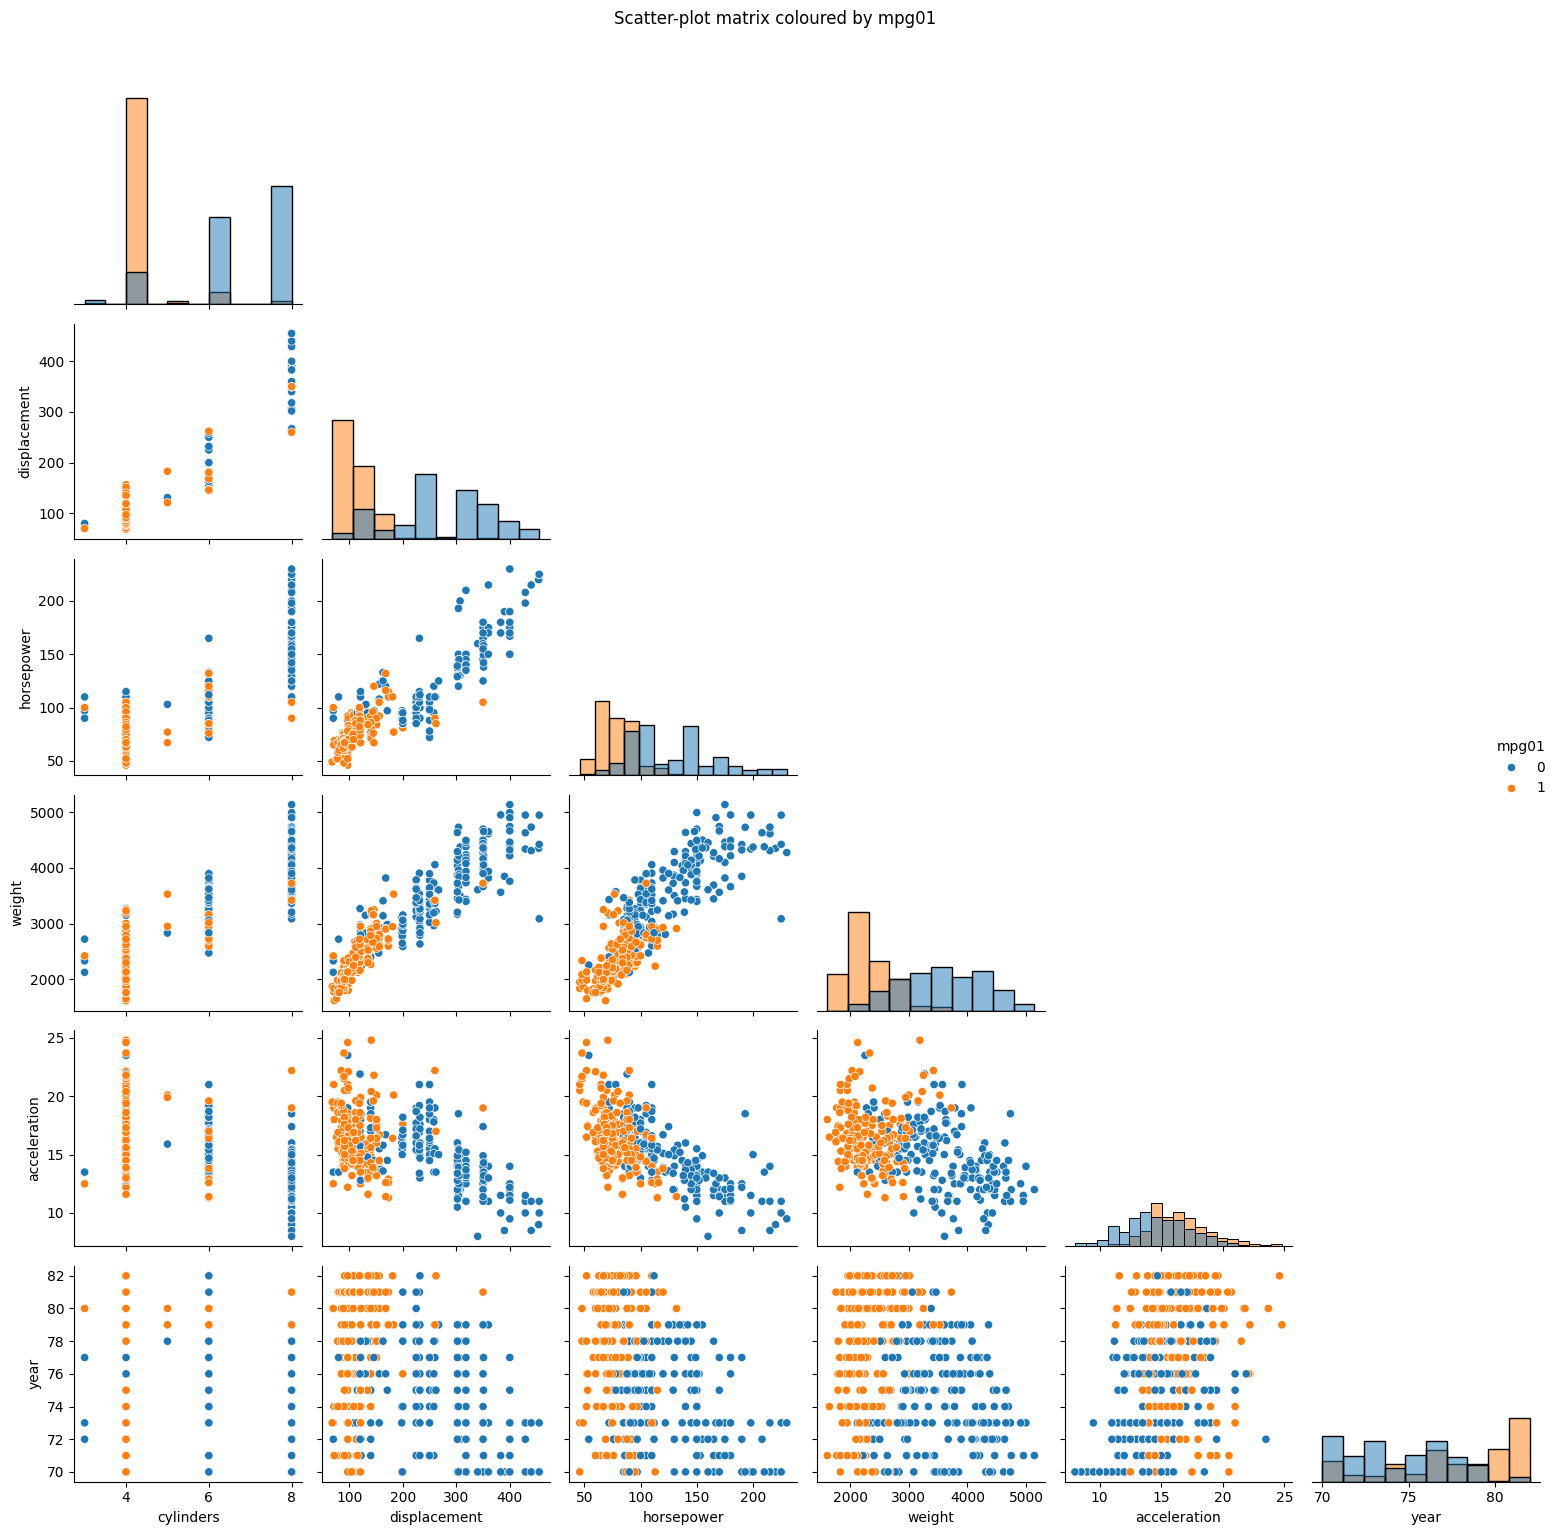

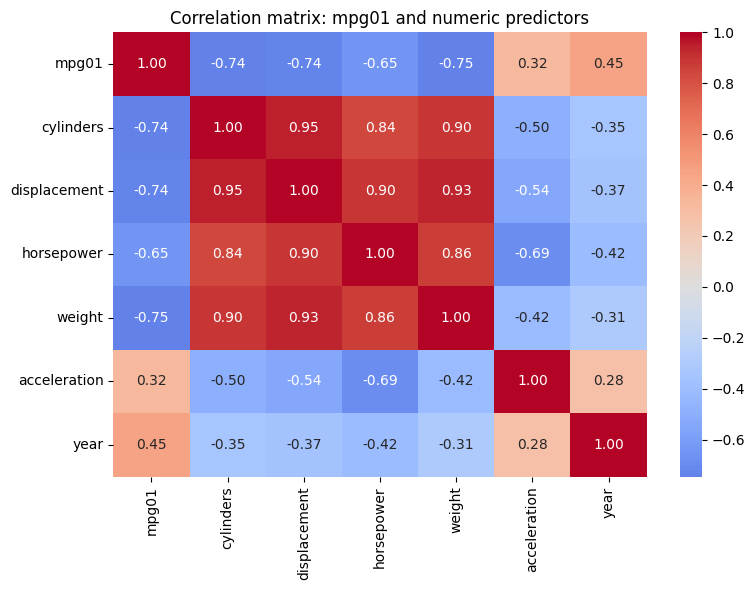


Top 3 predictors for mpg01 (by absolute correlation):
  weight        |r| = 0.746
  cylinders     |r| = 0.740
  displacement  |r| = 0.739


In [33]:
num_predictors = [
    "cylinders", "displacement", "horsepower",
    "weight", "acceleration", "year"
]

# 6) Scatter-plot matrix coloured by mpg01 --------------------------------
sns.pairplot(
    data=auto[["mpg01"] + num_predictors],
    hue="mpg01", diag_kind="hist", corner=True
)
plt.suptitle("Scatter-plot matrix coloured by mpg01", y=1.02)
plt.tight_layout()
plt.show()

# 7) Correlation matrix heat-map ------------------------------------------
corr = auto[["mpg01"] + num_predictors].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap="coolwarm", center=0
)
plt.title("Correlation matrix: mpg01 and numeric predictors")
plt.tight_layout()
plt.show()

# 8) Top three predictors by |correlation| with mpg01 ----------------------
top3 = (
    corr["mpg01"]
    .drop("mpg01")
    .abs()
    .sort_values(ascending=False)
    .head(3)
)

print("\nTop 3 predictors for mpg01 (by absolute correlation):")
for var, r in top3.items():
    print(f"  {var:<12}  |r| = {r:.3f}")

Cars that are lighter, have fewer cylinders, and smaller engine displacement almost always fall in the high-MPG class, as shown by the strong negative correlations (|r| ≈ 0.74) and the clear colour separation in the scatter-plot matrix.
These three attributes therefore offer the greatest predictive power for the binary target mpg01, with other variables adding little additional discrimination.

**(c)**

In [35]:
train_df, test_df = train_test_split(
    auto,
    test_size=0.15,        # 15 % for testing ⇒ 85 % for training
    random_state=42,       # reproducible split
    stratify=auto["mpg01"] # preserve class balance in each subset
)

print(f"Train size : {len(train_df)} rows")
print(f"Test  size : {len(test_df)} rows")

Train size : 337 rows
Test  size : 60 rows


**(d)**

In [38]:
features = ["weight", "cylinders", "displacement"]

X_train = train_df[features].values
y_train = train_df["mpg01"].values

X_test  = test_df[features].values
y_test  = test_df["mpg01"].values

def fit_and_score(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err    = 1 - accuracy_score(y_test, y_pred)
    print(f"{name:<18}  test error = {err:.3f}")
    return err

lda_model   = LinearDiscriminantAnalysis()
qda_model   = QuadraticDiscriminantAnalysis()

logreg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver="lbfgs")
)

nb_model = make_pipeline(
    StandardScaler(),
    GaussianNB()
)

print("=== Single-model results ===")
fit_and_score("LDA",              lda_model)
fit_and_score("QDA",              qda_model)
fit_and_score("Logistic Reg.",    logreg_model)
fit_and_score("Gaussian NB",      nb_model)

# 5) K-NN with varying k
print("\n=== K-NN (scaled) ===")
knn_errors = {}
for k in range(1, 16):           # k = 1 … 15
    knn = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k)
    )
    err = fit_and_score(f"KNN  k={k}", knn)
    knn_errors[k] = err

best_k   = min(knn_errors, key=knn_errors.get)
best_err = knn_errors[best_k]

print(f"\nBest K for KNN: k = {best_k}  (test error = {best_err:.3f})")

=== Single-model results ===
LDA                 test error = 0.167
QDA                 test error = 0.150
Logistic Reg.       test error = 0.167
Gaussian NB         test error = 0.150

=== K-NN (scaled) ===
KNN  k=1            test error = 0.117
KNN  k=2            test error = 0.117
KNN  k=3            test error = 0.100
KNN  k=4            test error = 0.117
KNN  k=5            test error = 0.100
KNN  k=6            test error = 0.083
KNN  k=7            test error = 0.100
KNN  k=8            test error = 0.083
KNN  k=9            test error = 0.150
KNN  k=10           test error = 0.150
KNN  k=11           test error = 0.133
KNN  k=12           test error = 0.150
KNN  k=13           test error = 0.150
KNN  k=14           test error = 0.150
KNN  k=15           test error = 0.150

Best K for KNN: k = 6  (test error = 0.083)


K-NN is clearly the winner on this data.
With the three strongest predictors (weight, cylinders, displacement) it achieves the lowest misclassification rate ≈ 8 % when k = 6 (and identically for k = 8) comfortably outperforming all parametric methods:

- K-NN (k = 6, 8) test error ≈ 0.083

- QDA/Gaussian NB test error ≈ 0.150

- LDA/Logistic regression test error ≈ 0.167

Thus, a moderate neighbourhood size of six provides the best balance between variance (k too small) and bias (k too large) for separating high and low MPG cars in this feature space.

---
## Question 5
*15 points*
![Logo Python](15.png)

**(a)**

In [41]:
df = pd.read_csv("Awards_data.csv")

train = df.iloc[:190].copy()
test  = df.iloc[190:].copy()

pois_res = smf.glm(
    formula = "num_awards ~ math + C(prog)",
    data    = train,
    family  = sm.families.Poisson()
).fit()

print(pois_res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_awards   No. Observations:                  190
Model:                            GLM   Df Residuals:                      186
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -166.17
Date:                Wed, 11 Jun 2025   Deviance:                       176.60
Time:                        13:37:16   Pearson chi2:                     203.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3599
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.4117      0.745     -7.263   

**(b)**

In [43]:
test["pred_awards"] = pois_res.predict(test)

#  Test MSE
mse = mean_squared_error(test["num_awards"], test["pred_awards"])

print("Test MSE (Poisson regression):", round(mse, 3))

print(test[["num_awards", "pred_awards"]])

Test MSE (Poisson regression): 2.095
     num_awards  pred_awards
190           0     2.106669
191           1     1.571808
192           2     2.438905
193           5     2.438905
194           1     1.089941
195           2     2.438905
196           2     1.507137
197           1     2.438905
198           0     2.624183
199           3     2.823536
